<a href="https://colab.research.google.com/github/KS0999/ML/blob/main/Multiple_Class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import requests
from pathlib import Path
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
X,y = make_blobs(n_samples = 1000,
                 n_features = 2, # as ur model input
                 centers = 4, # same concept as input but this is for output
                 cluster_std = 1.0, # close to 0 it will be more concentrated
                 random_state = 1)

In [4]:
# switch to numpy so we can to train/test and also plot the figure
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.LongTensor)

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                test_size = 0.2, # 20% for test
                                                train_size = 0.8, # 80% for train
                                                random_state = 1,)
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [6]:
# pandas dataframe just another foramt about dictionary
blobs = pd.DataFrame ({"X1":X[:,0],
                      "X2":X[:,1],
                      "label":y})
blobs

,X1,X2,label
0,-10.457655,-3.308995,1
1,-5.909620,-7.807170,2
2,-1.004980,4.355301,0
3,-6.637849,-4.520853,3
4,-6.346666,-8.899402,2
...,...,...,...
995,-10.867721,-3.584158,1
996,-7.377485,-8.052025,2
997,-4.452645,6.344018,0
998,-2.441472,3.968981,0


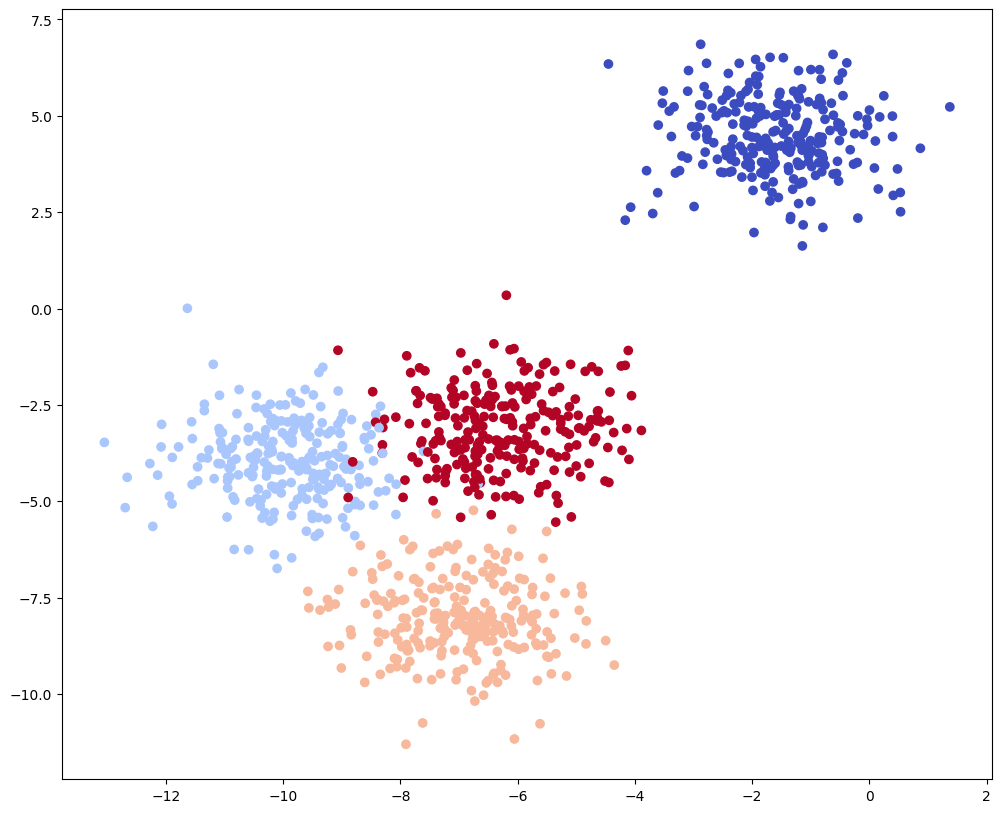

In [7]:
plt.figure(figsize=(12,10))
plt.scatter(X[:,0], X[:,1], c = y, cmap = 'coolwarm', marker = 'o') # marker is a signal to show the plot ,u can change any style btw.

In [8]:
class blobsModel(nn.Module):
  def __init__(self,input_features,out_features,hidden_unit = 8):
    super().__init__()
    self.layer = nn.Sequential(
          nn.Linear(in_features = input_features,out_features = hidden_unit),
          nn.ReLU(),
          nn.Linear(in_features = hidden_unit,out_features = hidden_unit),
          nn.ReLU(),
          nn.Linear(in_features = hidden_unit,out_features = out_features)
      )
  def forward(self,x):
    return self.layer(x)

In [9]:
model_blobs = blobsModel(input_features = 2,
                         out_features = 4,
                         hidden_unit = 8).to(device)
model_blobs

blobsModel(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [10]:
model_blobs.state_dict()

OrderedDict([('layer.0.weight',
              tensor([[ 0.3051,  0.2135],
                      [-0.6903, -0.2758],
                      [-0.6801,  0.0185],
                      [-0.3189, -0.2215],
                      [ 0.2464, -0.0062],
                      [ 0.5117, -0.2925],
                      [ 0.4108, -0.2875],
                      [ 0.5892,  0.5955]], device='cuda:0')),
             ('layer.0.bias',
              tensor([-0.0905,  0.3327,  0.4714, -0.3601,  0.6254, -0.0049, -0.4923,  0.4355],
                     device='cuda:0')),
             ('layer.2.weight',
              tensor([[-2.6023e-01, -2.4956e-01,  1.8188e-01, -2.7171e-01,  2.1828e-04,
                       -1.4804e-01,  2.9249e-02, -1.9115e-01],
                      [ 3.4918e-01,  1.1289e-01, -2.1291e-01, -3.3725e-01, -3.3177e-01,
                        3.5158e-01, -2.3499e-01, -3.2273e-01],
                      [ 1.2424e-02, -1.8566e-01, -1.0747e-01, -2.3257e-02,  2.2161e-01,
                       -1

In [11]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(lr = 0.1,
                            params = model_blobs.parameters())

In [12]:
y[:5]

tensor([1, 2, 0, 3, 2])

In [14]:
X_train,X_test = X_train.to(device),X_test.to(device)
y_train,y_test = y_train.to(device),y_test.to(device)

In [15]:
# raw logit
model_blobs.eval()
with torch.inference_mode():
  y_logit = model_blobs(X_test).squeeze()
y_logit[:10]

tensor([[ 0.3084,  0.3159,  0.6179, -0.5781],
        [ 0.1200,  0.3206,  0.4498, -0.3731],
        [ 0.1394,  0.3201,  0.4671, -0.3942],
        [ 0.0899,  0.3213,  0.4230, -0.3404],
        [ 0.1220,  0.3205,  0.4516, -0.3753],
        [ 0.2480,  0.3174,  0.5640, -0.5123],
        [ 0.2390,  0.3176,  0.5559, -0.5025],
        [ 0.1314,  0.3203,  0.4600, -0.3855],
        [ 0.2677,  0.3169,  0.5816, -0.5338],
        [ 0.2714,  0.3168,  0.5849, -0.5378]], device='cuda:0')

In [16]:
# prediction probaility
y_pred_pro = torch.softmax(y_logit,dim = 1)
y_pred_pro[:10]

tensor([[0.2644, 0.2664, 0.3603, 0.1090],
        [0.2368, 0.2894, 0.3293, 0.1446],
        [0.2397, 0.2871, 0.3326, 0.1406],
        [0.2322, 0.2927, 0.3240, 0.1510],
        [0.2371, 0.2891, 0.3296, 0.1442],
        [0.2557, 0.2741, 0.3507, 0.1195],
        [0.2544, 0.2752, 0.3493, 0.1212],
        [0.2385, 0.2881, 0.3313, 0.1422],
        [0.2585, 0.2716, 0.3539, 0.1160],
        [0.2591, 0.2711, 0.3545, 0.1153]], device='cuda:0')

In [17]:
y_pred_label = torch.argmax(y_pred_pro,dim = 1)
y_pred_label

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2,
        2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2,
        2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2,
        2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 1], device='cuda:0')

In [18]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [19]:
print(y_logit[:10])
print(y_train[:10])

tensor([[ 0.3084,  0.3159,  0.6179, -0.5781],
        [ 0.1200,  0.3206,  0.4498, -0.3731],
        [ 0.1394,  0.3201,  0.4671, -0.3942],
        [ 0.0899,  0.3213,  0.4230, -0.3404],
        [ 0.1220,  0.3205,  0.4516, -0.3753],
        [ 0.2480,  0.3174,  0.5640, -0.5123],
        [ 0.2390,  0.3176,  0.5559, -0.5025],
        [ 0.1314,  0.3203,  0.4600, -0.3855],
        [ 0.2677,  0.3169,  0.5816, -0.5338],
        [ 0.2714,  0.3168,  0.5849, -0.5378]], device='cuda:0')
tensor([1, 2, 2, 0, 2, 1, 2, 2, 1, 3], device='cuda:0')


In [27]:
X_train.device

device(type='cuda', index=0)

In [28]:
y_logit.device

device(type='cuda', index=0)

In [39]:
model_blobs.to(device)

blobsModel(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [41]:
torch.manual_seed(1)
epochs = 2000

X_train,X_test = X_train.to(device),X_test.to(device)
y_train,y_test = y_train.to(device),y_test.to(device)

for epoch in range(epochs):
  model_blobs.train()
  # do the forward pass
  y_logit = model_blobs(X_train)
  y_pred = torch.argmax(torch.softmax(y_logit,dim = 1),dim = 1)

  # calculate the loss & acc
  loss = loss_fn(y_logit,y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # optimizer zero grad
  optimizer.zero_grad()
  # loss backward
  loss.backward()

  # optimizer step
  optimizer.step()

  model_blobs.eval()
  # do the forward pass
  test_logit = model_blobs(X_test)
  test_pred = torch.argmax(torch.softmax(test_logit,dim = 1),dim = 1)

  #calculate the loss & acc
  test_loss = loss_fn(test_logit,y_test)
  test_acc = accuracy_fn(y_true = y_test,
                         y_pred = test_pred)

  if (epoch%100==0):
    print(f"Epoch:{epoch},Loss:{loss:.5f},Accuracy:{acc}%,Test_Loss:{test_loss:.5f},Test_Accuracy:{test_acc}%")

Epoch:0,Loss:0.23544,Accuracy:95.75%,Test_Loss:0.23579,Test_Accuracy:87.0%
Epoch:100,Loss:0.19856,Accuracy:96.0%,Test_Loss:0.19797,Test_Accuracy:92.0%
Epoch:200,Loss:0.17075,Accuracy:96.25%,Test_Loss:0.16916,Test_Accuracy:93.5%
Epoch:300,Loss:0.14971,Accuracy:96.375%,Test_Loss:0.14861,Test_Accuracy:94.5%
Epoch:400,Loss:0.13415,Accuracy:96.875%,Test_Loss:0.13361,Test_Accuracy:95.0%
Epoch:500,Loss:0.12630,Accuracy:96.625%,Test_Loss:0.12810,Test_Accuracy:95.5%
Epoch:600,Loss:0.09294,Accuracy:98.25%,Test_Loss:0.09401,Test_Accuracy:96.5%
Epoch:700,Loss:0.25390,Accuracy:87.375%,Test_Loss:0.24620,Test_Accuracy:91.5%
Epoch:800,Loss:0.20399,Accuracy:90.25%,Test_Loss:0.41457,Test_Accuracy:84.5%
Epoch:900,Loss:0.06192,Accuracy:98.875%,Test_Loss:0.07284,Test_Accuracy:97.5%
Epoch:1000,Loss:0.06253,Accuracy:98.875%,Test_Loss:0.07346,Test_Accuracy:97.5%
Epoch:1100,Loss:0.05510,Accuracy:99.0%,Test_Loss:0.06653,Test_Accuracy:97.5%
Epoch:1200,Loss:0.05749,Accuracy:98.875%,Test_Loss:0.06911,Test_Accuracy

In [42]:
if os.path.isfile("helper_functions.py"):
  print(" helper_functions.py is exist ...")
else:
  print(" helper_functions.py isn't exist ! Preparing for download ...")
  url = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as file:
    file.write(url.content)

 helper_functions.py is exist ...


In [43]:
import helper_functions

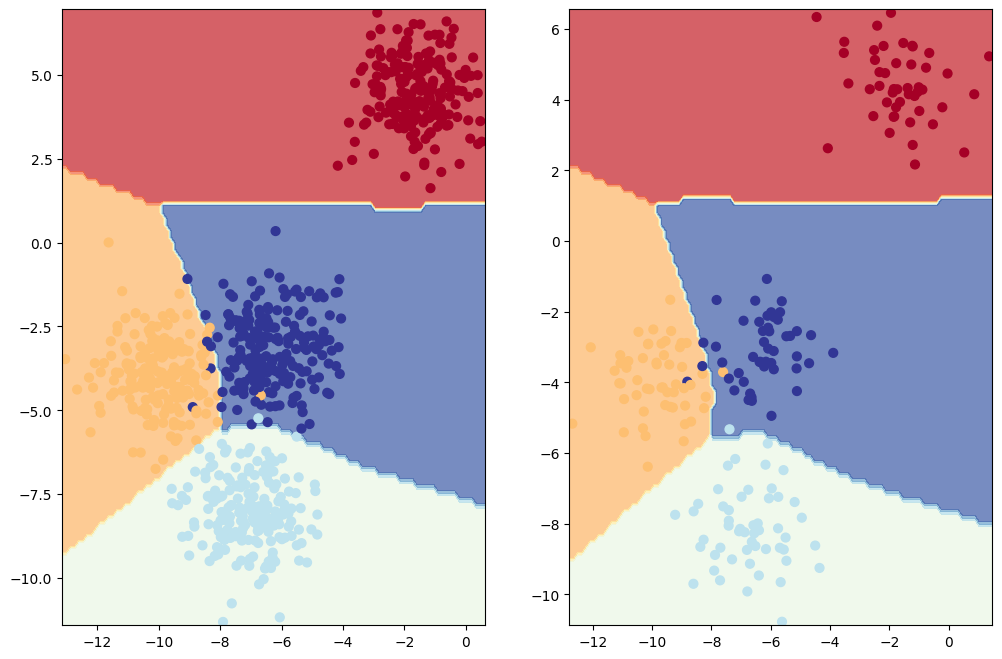

In [44]:
from helper_functions import plot_decision_boundary
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_decision_boundary(model_blobs,X_train,y_train)
plt.subplot(1,2,2)
plot_decision_boundary(model_blobs,X_test,y_test)